In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 7367 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['0_Normal', '1_Covid19', '2_Pneumonia']

In [8]:
len(dataset)

231

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2, 1, 0, 0, 1, 0,
       2, 0, 2, 0, 0, 2, 0, 2, 2, 0], dtype=int32)>>


2024-04-27 09:54:31.874392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[ 1.4968529   1.4968529   1.4968529 ]
  [ 8.861004    8.861004    8.861004  ]
  [13.246315   13.246315   13.246315  ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.461586    0.461586    0.461586  ]
  [ 6.8193398   6.8193398   6.8193398 ]
  [12.953457   12.953457   12.953457  ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.23013687  0.23013687  0.23013687]
  [ 4.4635544   4.4635544   4.4635544 ]
  [12.275944   12.275944   12.275944  ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.   

2024-04-27 09:54:40.376242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
train_ds=dataset.take(1766)
train_ds
len(train_ds)

231

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split *ds_size)
    val_size=int(val_split *ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
len(train_ds)

231

In [13]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

184

In [15]:
len(test_ds)

24

In [16]:
len(val_ds)

23

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/224)
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [22]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow import keras 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


In [23]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [24]:
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(dataset),activation='softmax')

In [25]:
model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

In [26]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
history = model.fit(train_ds, epochs=EPOCHS, 
                    steps_per_epoch=80,
                    validation_steps=10,
                    validation_data=val_ds)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.3007 - loss: 6.0565 - val_accuracy: 0.3875 - val_loss: 1.7170
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.4041 - loss: 1.5608 - val_accuracy: 0.4031 - val_loss: 1.3096
Epoch 3/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 4:16 5s/step - accuracy: 0.4700 - loss: 1.2756

2024-04-27 10:12:02.641727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4646 - loss: 1.2706 - val_accuracy: 0.4167 - val_loss: 1.2686
Epoch 4/50


2024-04-27 10:12:16.411221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 489s 6s/step - accuracy: 0.4492 - loss: 1.2331 - val_accuracy: 0.4094 - val_loss: 1.2470
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 669s 8s/step - accuracy: 0.4246 - loss: 1.2642 - val_accuracy: 0.4469 - val_loss: 1.2675
Epoch 6/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 6:51 7s/step - accuracy: 0.4093 - loss: 1.2699

2024-04-27 10:34:32.013575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4181 - loss: 1.2599 - val_accuracy: 0.4375 - val_loss: 1.3152
Epoch 7/50


2024-04-27 10:34:54.624511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 673s 8s/step - accuracy: 0.4612 - loss: 1.1399 - val_accuracy: 0.4344 - val_loss: 1.2496
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 677s 8s/step - accuracy: 0.4416 - loss: 1.1840 - val_accuracy: 0.3688 - val_loss: 1.2428
Epoch 9/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 7:05 8s/step - accuracy: 0.4810 - loss: 1.1244

2024-04-27 11:00:26.905228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.4615 - loss: 1.1375 - val_accuracy: 0.4271 - val_loss: 1.0541
Epoch 10/50


2024-04-27 11:00:50.422727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 700s 9s/step - accuracy: 0.4795 - loss: 1.0754 - val_accuracy: 0.4750 - val_loss: 1.2018
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 769s 10s/step - accuracy: 0.4621 - loss: 1.1164 - val_accuracy: 0.4406 - val_loss: 1.1526
Epoch 12/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 7:33 8s/step - accuracy: 0.4960 - loss: 1.0656

2024-04-27 11:28:34.202014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.4943 - loss: 1.0492 - val_accuracy: 0.4792 - val_loss: 1.0380
Epoch 13/50


2024-04-27 11:28:57.470180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 697s 9s/step - accuracy: 0.4927 - loss: 1.0297 - val_accuracy: 0.4719 - val_loss: 1.1148
Epoch 14/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 682s 9s/step - accuracy: 0.4922 - loss: 1.0617 - val_accuracy: 0.4250 - val_loss: 1.1023
Epoch 15/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 7:12 8s/step - accuracy: 0.5082 - loss: 1.0569

2024-04-27 11:55:01.170299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.4979 - loss: 1.0520 - val_accuracy: 0.3854 - val_loss: 1.2025
Epoch 16/50


2024-04-27 11:55:23.441045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 692s 9s/step - accuracy: 0.4988 - loss: 1.0312 - val_accuracy: 0.4125 - val_loss: 1.1206
Epoch 17/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 894s 11s/step - accuracy: 0.5010 - loss: 1.0186 - val_accuracy: 0.4344 - val_loss: 1.1160
Epoch 18/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 10:32 11s/step - accuracy: 0.4692 - loss: 1.0437

2024-04-27 12:26:21.724372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.4780 - loss: 1.0358 - val_accuracy: 0.4792 - val_loss: 1.1828
Epoch 19/50


2024-04-27 12:27:04.047090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 731s 9s/step - accuracy: 0.4916 - loss: 1.0177 - val_accuracy: 0.4469 - val_loss: 1.1321
Epoch 20/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 670s 8s/step - accuracy: 0.4893 - loss: 1.0299 - val_accuracy: 0.5156 - val_loss: 1.1238
Epoch 21/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 7:09 8s/step - accuracy: 0.5048 - loss: 1.0508

2024-04-27 12:53:29.411323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.4878 - loss: 1.0604 - val_accuracy: 0.4167 - val_loss: 1.1214
Epoch 22/50


2024-04-27 12:53:51.528048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 660s 8s/step - accuracy: 0.5015 - loss: 1.0093 - val_accuracy: 0.4563 - val_loss: 1.1312
Epoch 23/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.5018 - loss: 1.0110 - val_accuracy: 0.5000 - val_loss: 1.1392
Epoch 24/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 4:12 5s/step - accuracy: 0.5053 - loss: 1.0446

2024-04-27 13:13:22.808785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4979 - loss: 1.0348 - val_accuracy: 0.5104 - val_loss: 1.1086
Epoch 25/50


2024-04-27 13:13:36.209578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.4860 - loss: 1.0342 - val_accuracy: 0.4688 - val_loss: 1.2447
Epoch 26/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.4914 - loss: 1.0298 - val_accuracy: 0.5063 - val_loss: 1.2054
Epoch 27/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.4585 - loss: 1.0887

2024-04-27 13:27:56.121846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4793 - loss: 1.0491 - val_accuracy: 0.4792 - val_loss: 1.1130
Epoch 28/50


2024-04-27 13:28:08.315120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1482s 19s/step - accuracy: 0.5196 - loss: 1.0078 - val_accuracy: 0.3469 - val_loss: 1.3173
Epoch 29/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1745s 22s/step - accuracy: 0.5104 - loss: 0.9971 - val_accuracy: 0.4313 - val_loss: 1.1117
Epoch 30/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 14:39 16s/step - accuracy: 0.5225 - loss: 0.9666

2024-04-27 14:28:49.330808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 477s 5s/step - accuracy: 0.5122 - loss: 0.9709 - val_accuracy: 0.3333 - val_loss: 1.1295
Epoch 31/50


2024-04-27 14:29:52.542953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1705s 22s/step - accuracy: 0.4975 - loss: 1.0310 - val_accuracy: 0.4812 - val_loss: 1.1742
Epoch 32/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.5250 - loss: 0.9642 - val_accuracy: 0.4313 - val_loss: 1.0844
Epoch 33/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.5256 - loss: 0.9806

2024-04-27 15:06:13.804348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5004 - loss: 1.0153 - val_accuracy: 0.4167 - val_loss: 1.1109
Epoch 34/50


2024-04-27 15:06:26.516988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - accuracy: 0.5192 - loss: 0.9956 - val_accuracy: 0.3969 - val_loss: 1.1082
Epoch 35/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.5201 - loss: 0.9716 - val_accuracy: 0.4594 - val_loss: 1.1744
Epoch 36/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.5063 - loss: 0.9985

2024-04-27 15:20:45.325021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4982 - loss: 1.0036 - val_accuracy: 0.4688 - val_loss: 1.1057
Epoch 37/50


2024-04-27 15:20:58.527289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.5401 - loss: 0.9521 - val_accuracy: 0.4781 - val_loss: 1.0879
Epoch 38/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.5302 - loss: 0.9710 - val_accuracy: 0.4281 - val_loss: 1.1053
Epoch 39/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.4762 - loss: 1.0412

2024-04-27 15:35:04.664520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4828 - loss: 1.0335 - val_accuracy: 0.4583 - val_loss: 1.1211
Epoch 40/50


2024-04-27 15:35:17.057566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.4893 - loss: 1.0033 - val_accuracy: 0.3906 - val_loss: 1.1269
Epoch 41/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 409s 5s/step - accuracy: 0.5177 - loss: 0.9727 - val_accuracy: 0.4125 - val_loss: 1.1525
Epoch 42/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 4:18 5s/step - accuracy: 0.5135 - loss: 1.0052

2024-04-27 15:50:07.133337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5141 - loss: 1.0007 - val_accuracy: 0.5104 - val_loss: 0.9724
Epoch 43/50


2024-04-27 15:50:20.838394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 411s 5s/step - accuracy: 0.5253 - loss: 0.9766 - val_accuracy: 0.4344 - val_loss: 1.0988
Epoch 44/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 417s 5s/step - accuracy: 0.5179 - loss: 0.9749 - val_accuracy: 0.4344 - val_loss: 1.1424
Epoch 45/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 4:15 5s/step - accuracy: 0.5485 - loss: 0.9667

2024-04-27 16:05:57.804573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.5419 - loss: 0.9738 - val_accuracy: 0.4688 - val_loss: 1.1254
Epoch 46/50


2024-04-27 16:06:11.645384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 417s 5s/step - accuracy: 0.5392 - loss: 0.9508 - val_accuracy: 0.4563 - val_loss: 1.3186
Epoch 47/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 426s 5s/step - accuracy: 0.5422 - loss: 0.9760 - val_accuracy: 0.4594 - val_loss: 1.0514
Epoch 48/50
24/80 ━━━━━━━━━━━━━━━━━━━━ 4:21 5s/step - accuracy: 0.5126 - loss: 0.9817

2024-04-27 16:22:06.506322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5099 - loss: 0.9857 - val_accuracy: 0.5938 - val_loss: 1.0076
Epoch 49/50


2024-04-27 16:22:20.880586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.5418 - loss: 0.9436 - val_accuracy: 0.4844 - val_loss: 1.0988
Epoch 50/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.4896 - loss: 1.0474 - val_accuracy: 0.4406 - val_loss: 1.1119


In [29]:
score= model.evaluate(test_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.4539 - loss: 1.0835


In [30]:
score

[1.0858246088027954, 0.4427083432674408]

In [31]:
acc=history.history['accuracy']
val_acc =history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [32]:
for image_batch,labels_batch in test_ds.take(1):
    
    print(image_batch[0].numpy())

[[[15.        15.        15.       ]
  [15.209633  15.209633  15.209633 ]
  [15.447376  15.447376  15.447376 ]
  ...
  [15.083984  15.083984  15.083984 ]
  [15.706383  15.706383  15.706383 ]
  [15.916016  15.916016  15.916016 ]]

 [[14.769207  14.769207  14.769207 ]
  [14.6845665 14.6845665 14.6845665]
  [13.748047  13.748047  13.748047 ]
  ...
  [15.894199  15.894199  15.894199 ]
  [15.251953  15.251953  15.251953 ]
  [15.        15.        15.       ]]

 [[13.593529  13.593529  13.593529 ]
  [13.55373   13.55373   13.55373  ]
  [13.        13.        13.       ]
  ...
  [15.336491  15.336491  15.336491 ]
  [15.460274  15.460274  15.460274 ]
  [16.189232  16.189232  16.189232 ]]

 ...

 [[87.57713   87.57713   87.57713  ]
  [71.99834   71.99834   71.99834  ]
  [67.99724   67.99724   67.99724  ]
  ...
  [22.419922  22.419922  22.419922 ]
  [33.039536  33.039536  33.039536 ]
  [47.583614  47.583614  47.583614 ]]

 [[67.17609   67.17609   67.17609  ]
  [64.30762   64.30762   64.30762  ]


2024-04-27 16:50:53.336934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-27 16:50:53.535435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


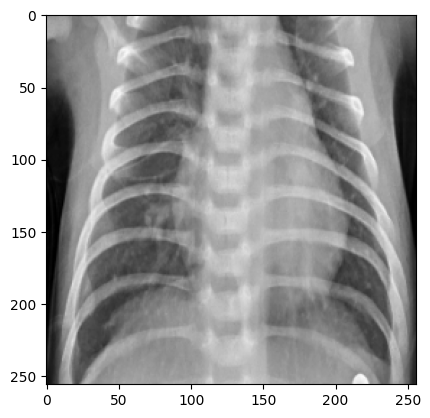

In [33]:
for image_batch,labels_batch in test_ds.take(1):
    
    plt.imshow(image_batch[0].numpy().astype('uint8'))

first image to predict
actual label: 1_Covid19
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[3.79369318e-01 7.15599656e-02 5.49069464e-01 3.35472294e-09
 1.43544149e-14 1.03225855e-14 5.36713642e-12 2.17202456e-09
 5.20394173e-16 8.99510344e-16 6.88783405e-12 4.64966624e-15
 8.98580937e-16 4.49019375e-13 8.46440620e-17 6.14830427e-15
 3.77422248e-19 4.93176940e-16 3.49503456e-12 1.09946240e-14
 2.21719124e-14 2.57835003e-16 4.81976994e-15 5.33175841e-17
 1.37019020e-12 3.03834310e-14 1.26137408e-11 6.71146472e-11
 7.61284922e-15 7.35406626e-15 7.26455623e-17 4.75258201e-15
 1.44665011e-14 2.53042254e-10 8.01224267e-13 6.19066972e-14
 2.89304388e-13 3.67534535e-13 5.68710660e-12 6.59217472e-13
 7.88282911e-11 3.77297117e-11 3.99667716e-10 1.96168920e-19
 2.16543924e-07 3.28847938e-14 2.20050893e-13 5.18994504e-16
 1.02101782e-16 2.78542001e-13 1.71917577e-10 3.06838976e-09
 2.27900424e-12 1.21110637e-16 4.13294859e-13 8.16689686e-15
 2.38803626e-14 5.30988310e-15 9.02817372e-16 1.47805067e-13
 4

2024-04-27 16:50:58.503883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


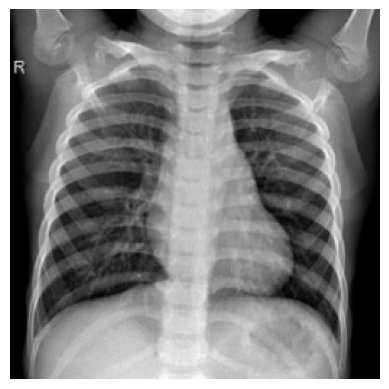

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2024-04-27 16:51:00.432004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


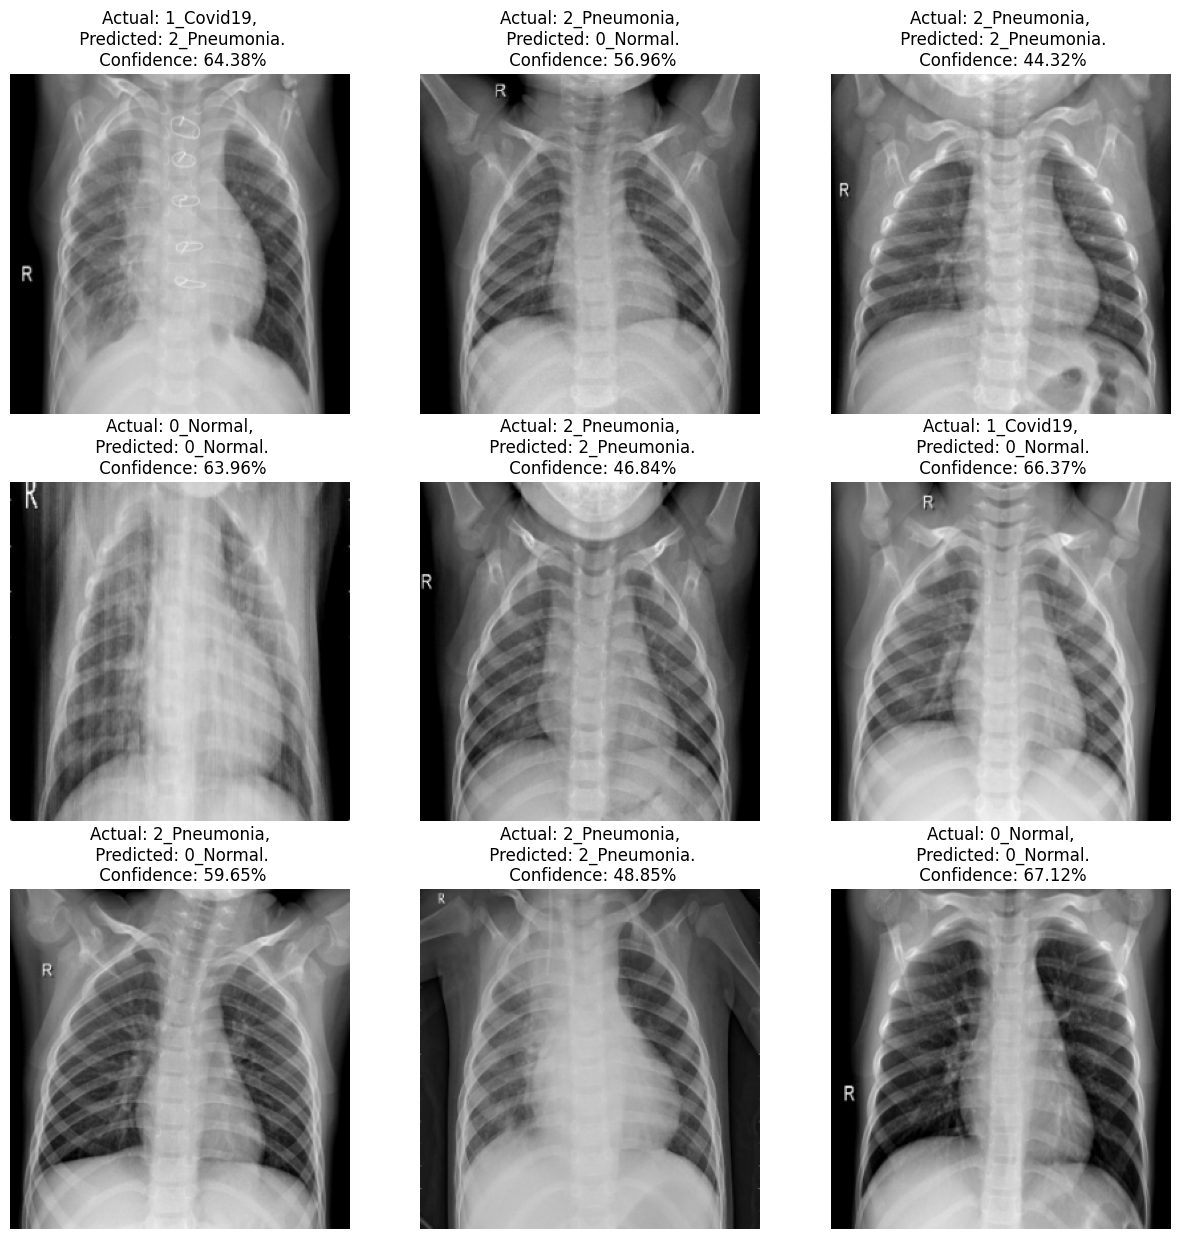

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
import os

model_version = 1
model_dir = "./model1"

# Check if the directory exists, create it if not
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Now proceed with finding existing models in the directory
for filename in os.listdir(model_dir):
    try:
        version = int(filename)
        model_version = max(model_version, version)
    except ValueError:
        pass
model_version += 1

# Save the trained model (choose either .h5 or .keras extension)
model.save(f"{model_dir}/{model_version}.h5")  # Use .h5 for HDF5 format
# or
# model.save(f"{model_dir}/{model_version}.keras")  # Use .keras for native Keras format

print(f"Model saved to: {model_dir}/{model_version}.h5")

Model saved to: ./model1/2.h5
